In [5]:
import importlib
import os
import fnmatch
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter
import csv
from sklearn import tree
import sys
sys.stdout.flush()
import math
import matplotlib.pyplot as plt
from matplotlib.table import Table
import segment_cluster as sc
import importlib
importlib.reload(sc)
from sklearn.cluster import KMeans
import pandas as pd

np.random.seed(0)


In [6]:
#set the data directory; asimov or desk6
cwd = os.getcwd()
if cwd.split("/")[1] == "home":
    data_path="/home/jkok1g14/Documents/GRS1915+105/data/Std1_PCU2"
elif cwd.split("/")[1] == "export":
    data_path="/export/data/jakubok/GRS1915+105/Std1_PCU2"
else:
    print("Set the path of data directory!", Flush=True)

#creates a dictionary of observation_ID: "state" items for labeled observations
clean_belloni = open('1915Belloniclass_updated.dat')
lines = clean_belloni.readlines()
states = lines[0].split()
belloni_clean = {}
for h,l in zip(states, lines[1:]):
    belloni_clean[h] = l.split()
    #state: obsID1, obsID2...
ob_state = {}
for state, obs in belloni_clean.items():
    if state == "chi1" or state == "chi2" or state == "chi3" or state == "chi4": state = "chi"
    for ob in obs:
        ob_state[ob] = state

#creates a list of observation IDs of labelled observations with available data
available = []
pool=[]
for root, dirnames, filenames in os.walk(data_path):
    for filename in fnmatch.filter(filenames, "*_std1_lc.txt"):#where _std1_lc.txt is the extension used for the Standard 1 PCU2 data
        available.append(filename)
for ob, state in ob_state.items():
    if ob+"_std1_lc.txt" in available:
        pool.append(ob)  

#create a list of arrays with time and counts data for the set of labelled observations
lc_dirs=[]
lcs=[]
ids=[]
for root, dirnames, filenames in os.walk(data_path):    
    for filename in fnmatch.filter(filenames, "*_std1_lc.txt"):
        if filename.split("_")[0] in pool:
            lc_dirs.append(os.path.join(root, filename))

            
#make 3D arrays for light curves, with rows of time, count rate and error values
for lc in lc_dirs:
    ids.append(lc.split("/")[-1].split("_")[0])
    time, counts, err = np.loadtxt(lc).T
    ###1s binning and time check to eliminate points outside of GTIs
    f8t = np.mean(time[:(len(time)//8)*8].reshape(-1, 8), axis=1)
    weights=err**-2
    f8c = np.average(counts[:(len(counts)//8)*8].reshape(-1, 8), axis=1, weights=weights[:(len(weights)//8)*8].reshape(-1, 8))
    f8e = np.sqrt(1/np.sum(weights[:(len(weights)//8)*8].reshape(-1, 8), axis=1))
    
    
    rm_points = []
    skip=False
    for i in range(len(f8t)-1):
        if skip==True:
            skip=False
            continue
        delta = f8t[i+1]-f8t[i]
        if delta > 1.0:
            rm_points.append(i+1)
            skip=True
    times=np.delete(f8t,rm_points)
    counts=np.delete(f8c,rm_points)
    errors=np.delete(f8e, rm_points)
    lcs.append(np.stack((times,counts, errors)))#a list of light curve 3D arrays
    #create a list of observation ids
    lc_classes=[]
    for i in ids:
        lc_classes.append(ob_state[i])


/export/data/jakubok/software/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in power
/export/data/jakubok/software/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:388: RuntimeWarning: invalid value encountered in multiply
  avg = np.multiply(a, wgt, dtype=result_dtype).sum(axis)/scl


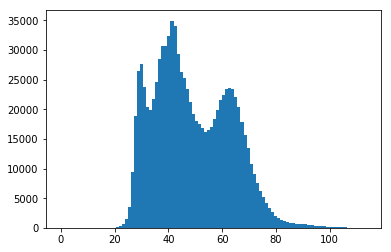

/export/data/jakubok/software/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/export/data/jakubok/software/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


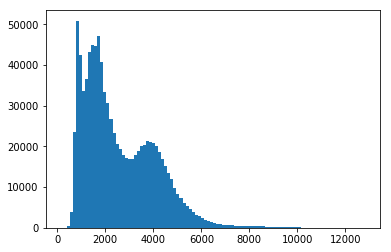

In [35]:
all_errors=lcs[0][2]
for lc in lcs[1:]:
    all_errors=np.hstack((all_errors,lc[2]))
plt.hist(all_errors, bins=100)
plt.show()

all_errors=lcs[0][1]
for lc in lcs[1:]:
    all_errors=np.hstack((all_errors,lc[1]))
plt.hist(all_errors, bins=100)
plt.show()

In [7]:
all_errors=np.array([])
all_counts=np.array([])

for lc in lc_dirs:
    ids.append(lc.split("/")[-1].split("_")[0])
    time, counts, err = np.loadtxt(lc).T
    all_counts=np.hstack((all_counts,counts))
    all_errors=np.hstack((all_errors,err))

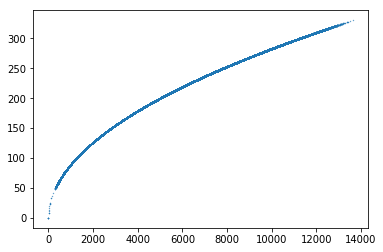

In [8]:
plt.scatter(all_counts, all_errors, s=0.1)

In [9]:
np.sqrt(2000)
#https://scipy-cookbook.readthedocs.io/items/FittingData.html

44.721359549995796

In [ ]:
lc_classes=[]
for i in ids:
    lc_classes.append(ob_state[i])

drop_classes=[]
for clas, no in Counter(lc_classes).items():
    if no<7:
        drop_classes.append(clas)

lcs_abu = []
classes_abu = []
ids_abu = []
for n, lc in enumerate(lc_classes):
    if lc not in drop_classes:
        classes_abu.append(lc)
        lcs_abu.append(lcs[n])
        ids_abu.append(ids[n])  
#a list of light curve 2D arrays of classes with at least 7 light curves
x_train, x_test, y_train, y_test, id_train, id_test = train_test_split(lcs_abu, classes_abu, ids_abu, test_size=0.25, stratify=classes_abu)

rho_file=np.loadtxt("synthetic_rhos.csv", delimiter=',')
rho_train, rho_valid, rho_train_ids, rho_valid_ids= train_test_split(rho_file, list(range(len(rho_file))) ,test_size=0.25)

#lists for the validation results 
#numbers of clusters and segment lengths to be tested
reco_error=[]
#reco_classes=[]
k_clusters=[50]
seg_lens=[8]
classes=list(set(y_train))
print(classes, flush=True)
for k_id, k_cluster in enumerate(k_clusters):
    for len_id, seg_len in enumerate(seg_lens):
        # calculate the slide values
        seg_slides=[1]
        for slide_id, seg_slide in enumerate(seg_slides):
            #leave one out cross validation
            
            
            
            ##train the model
            #loop throught the light curves of a given class and segments them
            all_train_segments=[]
            for rho in rho_train:
                train_segments=sc.segmentation(rho, seg_len, seg_slide, time_stamps=False)
                all_train_segments.append(train_segments)
            all_train_segments=np.vstack(all_train_segments)
            #cluster the segments
            cluster=KMeans(n_clusters=k_cluster, random_state=0)
            cluster.fit(all_train_segments)

            ### reconstruction: complete for every validation observation in leave-one-out. Then do once for lcs of all other classes
            for n_rho, rho in enumerate(rho_valid):
                valid_segments= sc.segmentation(rho, seg_len, seg_len , time_stamps=False)
                reco = sc.reconstruct(valid_segments, rho, cluster, rel_offset=False, seg_slide=seg_len)
                error=np.sqrt(np.mean((rho[seg_len:-seg_len]-reco[seg_len:-seg_len])**2))
                reco_error.append((k_id,len_id,slide_id,len(classes)+1, n_rho, error))
                print((k_id,len_id,slide_id,len(classes), n_rho, error), flush=True)
            
            
            
            #reconstruction loop through light curves for every class other than rho              
            for n_valid, valid_class in enumerate(classes):
                validation_ids=np.where(np.array(y_train)=='{}'.format(valid_class))[0]
                for ts_id in validation_ids:
                    valid_ts=x_train[ts_id]
                    valid_segments= sc.segmentation(valid_ts, seg_len, seg_len , time_stamps=True)
                    reco = sc.reconstruct(valid_segments, valid_ts, cluster, rel_offset=False, seg_slide=seg_len)
                    error=np.sqrt(np.mean((valid_ts[1][seg_len:-seg_len]-reco[1][seg_len:-seg_len])**2))
                    reco_error.append((k_id,len_id,slide_id,n_valid,int(id_train[ts_id].replace("-","")), error))
                    print((k_id,len_id,slide_id,n_valid,int(id_train[ts_id].replace("-","")), error))
reco_error_ar=np.array(reco_error)
print(classes, flush=True)
np.savetxt("valid_results_20190430.csv", reco_error_ar, delimiter=",") 

In [ ]:
# fold
period = np.pi # period (must be known already!)
foldTimes = time / period # divide by period to convert to phase
foldTimes = foldTimes % 1 # take fractional part of phase only (i.e. disc
ard whole number part)
# plot folded lightcurve
plt.errorbar(foldTimes,flux,yerr=err,linestyle='none',marker='o')
plt.show()


# bin
nbins = 30
# chosen number of bins across the period
width = 1.0/float(nbins) # calculate the width of the bins; total lightcurve length/no. of bins

# create arrays for bin values and weights
bins = np.zeros(nbins)
weights = np.zeros(nbins)

# bin!
for i in range(len(flux)):
    n = int(foldTimes[i] / width) # calculate bin number for this value; finds the index of one of the 30 bins
    weight = err[i]**-2.0 # calculate weight == error^-2
    bins[n] += flux[i] * weight # add weighted value to bin (value timesweight)
    weights[n] += weight# add weight to bin weights
    

counts*err**-2

bins /= weights # normalise weighted values using sum of weights

binErr = np.sqrt(1.0/(weights)) # calculate bin errors from squared weights

binEdges = np.arange(nbins) * width # create array of bin edge values for plotting

plt.errorbar(binEdges,bins,yerr=binErr,linestyle='none',marker='o') #plot binned lightcurve
plt.show()